# Imports

In [1]:
%matplotlib widget

import sys, os, glob
import copy
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('https://github.com/vivekthampy/mpl_style/blob/main/mpl_style.txt')

import matplotlib as mpl

from matplotlib.ticker import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

from collections import OrderedDict

from skimage import io
import pandas as pd

from ipywidgets import *
from IPython.display import display

from scipy.signal import medfilt2d

import _pickle as pickle

import hdf5plugin, h5py
import pyFAI
import fabio
from xdart.utils import write_xye

from imageio import imwrite

plt.rcParams.update({'figure.max_open_warning': 50})

# Functions

In [36]:
def get_images(fname, im_range=np.s_[:]):
    try:
        with h5py.File(fname, mode='r') as f:
            try:
                img = np.asarray(f['entry']['data']['data'][im_range], dtype=float)
            except:
                print("Image number doesn't exist")
                return None

            img[:, 514:551, :] = np.nan
            img[:, 0, 1029] = np.nan
        
        return img
    except:
        print('Corrupt H5 File')
        return None

def get_single_image(fname, n):
    try:
        with h5py.File(fname, mode='r') as f:
            try:
                img = np.asarray(f['entry']['data']['data'][n], dtype=float)
            except:
                print("Image number doesn't exist")
                return None

            img[514:551, :] = np.nan
            img[0, 1029] = np.nan

        return img
    except:
        print('Corrupt H5 File')
        return None

def get_nImages(fname):
    try:
        with h5py.File(fname, mode='r') as f:
            try:
                nImages = len(f['entry']['data']['data'])
            except:
                print("No Images")
                return None

        return nImages
    except:
        print('Corrupt H5 File')
        return None
    
def get_tiff_array(fpaths, N):
    try:
        tiff_file = glob.glob(f'{fpaths[N-1]}/*.tif')[0]
    except IndexError:
        print('Image not found')
        return None
    
    img = fabio.open(tiff_file).data
    
    return img


def get_tiff_data(tiff_file, mask=None):
    img = (fabio.open(tiff_file).data).astype(float)
    
    if mask is not None:
        img[mask == 1] = np.nan

    return img

# Setup

## Data Dictionaries

In [3]:
All_IQs = OrderedDict()

# Data Reduction

## Paths

In [4]:
path       = r'F:\Molleighs battteries\Jun2022_2'
plot_path  = os.path.join(path, 'plots')

data_path  = os.path.join(path, 'reduce')

calib_path = path
save_path  = os.path.join(data_path, 'reduced_data')
xye_path  = os.path.join(save_path, 'xye_data')

calib_file = os.path.join(calib_path, 'LaB6_transmission_rock.poni')

### Initialize integrator

In [5]:
ai = pyFAI.load(calib_file)
default_mask = ai.mask

mask = default_mask.copy()

ai

Detector Eiger 4M	 PixelSize= 7.500e-05, 7.500e-05 m
Wavelength= 8.265613e-11m
SampleDetDist= 1.908018e-01m	PONI= 1.541279e-01, 8.518293e-02m	rot1=-0.003643  rot2= 0.002371  rot3= -0.000000 rad
DirectBeamDist= 190.804mm	Center: x=1145.039, y=2061.071 pix	Tilt=0.249 deg  tiltPlanRotation= 33.064 deg

In [19]:
img_paths = [
    r'F:\Molleighs battteries\Jun2022_2\reduce\Mo3Nb14O44_46C_5C\Mo3Nb14O44_mbp46C_5C_2_scan004',
    r'F:\Molleighs battteries\Jun2022_2\reduce\Mo3Nb14O44_46C_10C\Mo3Nb14O44_mbp46C_10C_2_scan001',

    r'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp17A_5C\PNb9O25_mbp17A_5C_scan002',
    r'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp17A_10C\PNb9O25_mbp17A_10C_scan001',

    r'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp29C_5C\PNb9O25_mbp29C_5C_scan005',
    r'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp29C_10C\PNb9O25_mbp29C_10C_scan003',

    r'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp29C_20C\PNb9O25_mbp29C_20C', # Loop with - numbers
    r'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp29C_40C',
]

#samples = sorted(list(set([s[:s.find('_scan')] for s in samples])))
sample_paths = {os.path.basename(img_path[:img_path.rfind('C')+1]):img_path for img_path in img_paths}
samples = sorted(list(sample_paths.keys()))
samples

['Mo3Nb14O44_mbp46C_10C',
 'Mo3Nb14O44_mbp46C_5C',
 'PNb9O25_mbp17A_10C',
 'PNb9O25_mbp17A_5C',
 'PNb9O25_mbp29C_10C',
 'PNb9O25_mbp29C_20C',
 'PNb9O25_mbp29C_40C',
 'PNb9O25_mbp29C_5C']

H5:
'F:\Molleighs battteries\Jun2022_2\reduce\Mo3Nb14O44_mbp46C_20C\Mo3Nb14O44_mbp46C_20C_try3_master'
'F:\Molleighs battteries\Jun2022_2\reduce\Mo3Nb14O44_mbp46C_40C\Mo3Nb14O44_mbp46C_40C_master'
'F:\Molleighs battteries\Jun2022_2\reduce\Mo3Nb14O44_mbp46C_60C\Mo3Nb14O44_mbp46C_60C_master'

'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp17A_20C\PNb9O25_mbp17A_20C_master'
'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp17A_40C\PNb9O25_mbp17A_40C_master'

'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp29C_60C\PNb9O25_mbp29C_60C_master'

Loop Scans:
'F:\Molleighs battteries\Jun2022_2\reduce\Mo3Nb14O44_46C_5C\Mo3Nb14O44_mbp46C_5C_2_scan004'
'F:\Molleighs battteries\Jun2022_2\reduce\Mo3Nb14O44_46C_10C\Mo3Nb14O44_mbp46C_10C_2_scan001'

'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp17A_5C\PNb9O25_mbp17A_5C_scan002'
'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp17A_10C\PNb9O25_mbp17A_10C_scan001'

'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp29C_5C\PNb9O25_mbp29C_5C_scan005'
'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp29C_10C\PNb9O25_mbp29C_10C_scan003'

'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp29C_20C\PNb9O25_mbp29C_20C' # Loop with - numbers
'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp29C_40C'


Nightmare:
'F:\Molleighs battteries\Jun2022_2\reduce\Mo3Nb14O44_mbp46C_slow'
'F:\Molleighs battteries\Jun2022_2\reduce\PNb9O25_mbp29C_slow'
'F:\Molleighs battteries\Jun2022_2\reduce\W3Nb14O44_mbp51F_slow'

In [32]:
def get_scans(sample_paths):
    FNames = OrderedDict()#{sample:[] for sample in samples})

    for scan, scan_path in sample_paths.items():
        img_paths = np.array(sorted(glob.glob(os.path.join(f'{scan_path}', f'*{scan}*.tif'))))
        if 'PNb9O25_mbp29C_20C' in scan_path:
            inds = np.argsort([int(p[p.rfind('-')+1:p.rfind('.tif')]) for p in img_paths])
            img_paths = img_paths[inds]
            
        FNames[scan] = list(img_paths)

    return FNames, samples

FNames, samples = get_scans(sample_paths)

for k, v in FNames.items():
    print(f'scan: {k}, nimages: {len(v)}')

scan: Mo3Nb14O44_mbp46C_5C, nimages: 397
scan: Mo3Nb14O44_mbp46C_10C, nimages: 796
scan: PNb9O25_mbp17A_5C, nimages: 199
scan: PNb9O25_mbp17A_10C, nimages: 448
scan: PNb9O25_mbp29C_5C, nimages: 399
scan: PNb9O25_mbp29C_10C, nimages: 793
scan: PNb9O25_mbp29C_20C, nimages: 2309
scan: PNb9O25_mbp29C_40C, nimages: 803


## Show Raw data

In [40]:
plt.ioff()
fig, ax1 = plt.subplots(ncols=1, figsize=(8.5,7))
plt.ion()
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.5)

scans = list(FNames.keys())

images, scan, im = None, None, None
NSlider=IntSlider(min=1, max=2, step=1, value=0)
@interact(Scan=Dropdown(options=scans, value=scans[-1]),
          N=NSlider,
          minmax=FloatRangeSlider(min=1, max=100, step=0.5, value=(5,98)))
def show_image(Scan, N, minmax):
    ax1.cla(); cax.cla()
    ax1.grid(False); cax.grid(False) 
    
    global images, scan, im
    
    scan = Scan
    NSlider.max = len(FNames[scan])
    
    N = min(N, len(FNames[scan]))
    im = get_tiff_data(FNames[scan][N], mask=mask)

    i1 = ax1.imshow(im, vmin=np.nanpercentile(im, minmax[0]), vmax=np.nanpercentile(im, minmax[1]))
    plt.colorbar(i1, cax=cax)
    
    ax1.set_title(f'{scan} - #{N}')
    
    fig.tight_layout()
    fig.show()

interactive(children=(Dropdown(description='Scan', index=7, options=('Mo3Nb14O44_mbp46C_5C', 'Mo3Nb14O44_mbp46…

# Integration

## I(Q) and I(2Th) Integration and save to XYE files

In [38]:
reprocess = True

for scan in scans[:]:
    im_range = np.s_[:]
        
    h5_path = save_path
    iq_file   = f'{h5_path}/IQ_{scan}.h5'
    if (os.path.exists(iq_file)) and (not reprocess):
        if scan not in All_IQs.keys():
            with h5py.File(iq_file, 'r') as h5file:
                q = h5file['q'].value
                i_q = h5file['i_q'].value
                All_IQs[scan] = (q, i_q)
        print('Scan: {} already processed'.format(scan))
        continue
        
    nn = 0        
    N = len(FNames[scan])
    for nn in range(N):
        im = get_tiff_data(FNames[scan][nn], mask=mask)
        if im is None:
            break

        # Write I(2th) to xye
        q, intensity = ai.integrate1d(im, npt=5000, mask=mask, unit='2th_deg')
        if nn == 0:
            os.makedirs(os.path.join(xye_path, f'{scan}'), exist_ok=True)
        fname = os.path.join(xye_path, f'{scan}', f'{scan}_{nn:04d}.xye')
        write_xye(fname, q, intensity, np.sqrt(abs(intensity)))

        # Get I(q)
        q, intensity = ai.integrate1d(im, npt=5000, mask=mask, unit='q_A^-1')
        if nn == 0:
            i_q = intensity
            i_q = i_q[np.newaxis, :]
        else:
            i_q = np.vstack((i_q, intensity))

        if np.mod(nn, 100) == 0:
            print('Image {} processed'.format(nn), end='\r')

    All_IQs[scan] = q, i_q

    # Save to H5 file
    with h5py.File(iq_file, 'w') as h5file:
        h5file.create_dataset('q', data=q)
        h5file.create_dataset('i_q', data=i_q)

    print('Scan: {} Processed'.format(scan))

Scan: Mo3Nb14O44_mbp46C_5C Processed
Scan: Mo3Nb14O44_mbp46C_10C Processed
Scan: PNb9O25_mbp17A_5C Processed
Scan: PNb9O25_mbp17A_10C Processed
Scan: PNb9O25_mbp29C_5C Processed
Scan: PNb9O25_mbp29C_10C Processed
Scan: PNb9O25_mbp29C_20C Processed
Scan: PNb9O25_mbp29C_40C Processed


## Plot WaterFall

interactive(children=(Dropdown(description='Scan', index=7, options=('Mo3Nb14O44_mbp46C_5C', 'Mo3Nb14O44_mbp46…

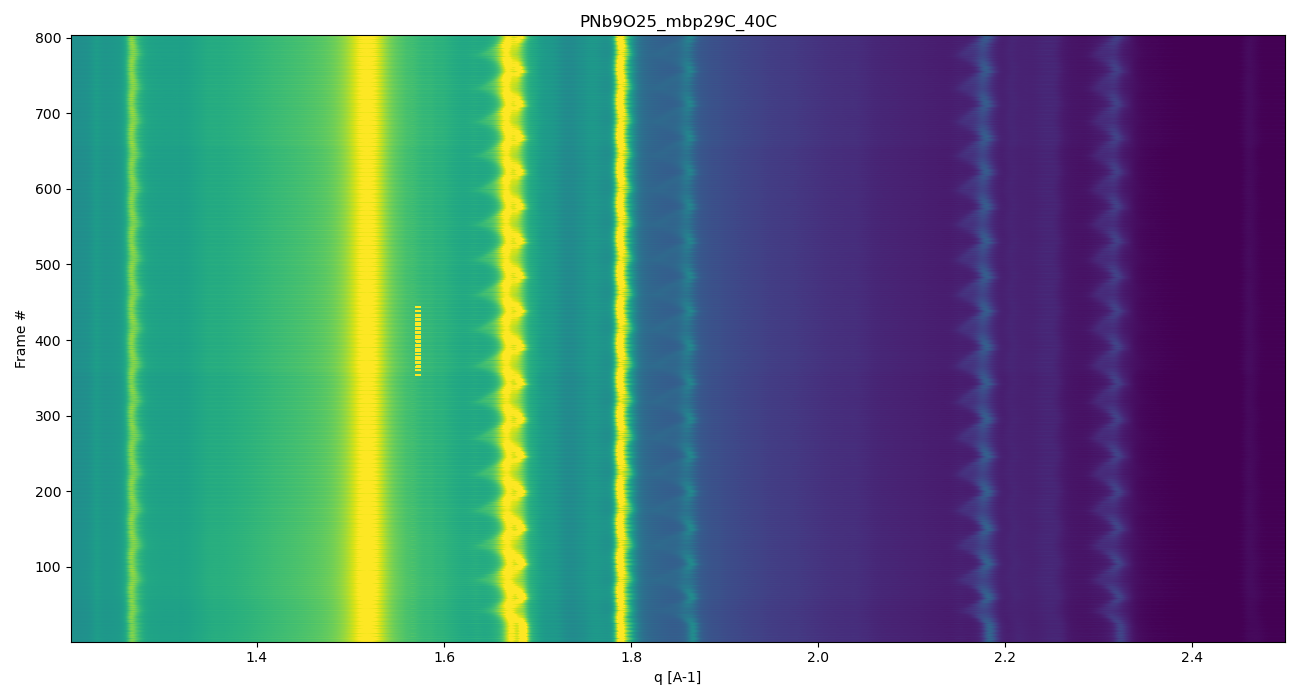

In [39]:
fig2, ax2 = plt.subplots(ncols=1, figsize=(13, 7))

processed_scans = [scan for scan in list(All_IQs.keys()) if
                   All_IQs[scan][1].shape[0] > 1]
                                         
NSlider=IntSlider(min=1, max=2, step=1, value=0)
@interact(Scan=Dropdown(options=processed_scans, value=processed_scans[-1]),
          xlim=FloatRangeSlider(min=0, max=6, value=(1.2, 2.5), step=0.1),
          minmax=FloatRangeSlider(min=0, max=100, step=0.5, value=(5,98))
         )
def show_iq(Scan, xlim, minmax):
    ax2.cla()
    ax2.grid(False)
    
    q_, i_q_ = All_IQs[Scan][0], All_IQs[Scan][1]
    inds = (q_ >= xlim[0]) & (q_ <= xlim[1])
    q, i_q = q_[inds], i_q_[:, inds]
    
    vminmax = np.nanpercentile(i_q, minmax)
    
    ax2.imshow(i_q, extent=(q.min(), q.max(), 1, i_q.shape[0]),
               vmin=vminmax[0], vmax=vminmax[1], aspect='auto',
               origin='lower')
    ax2.set_xlabel('q [A-1]')
    ax2.set_ylabel('Frame #')
    ax2.set_title('{}'.format(Scan))
    
    fig2.tight_layout()

## Plot I_Q

interactive(children=(Dropdown(description='Scan', index=1, options=('PNb9O25_mbp29C_slow', 'Mo3Nb14O44_mbp46C…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
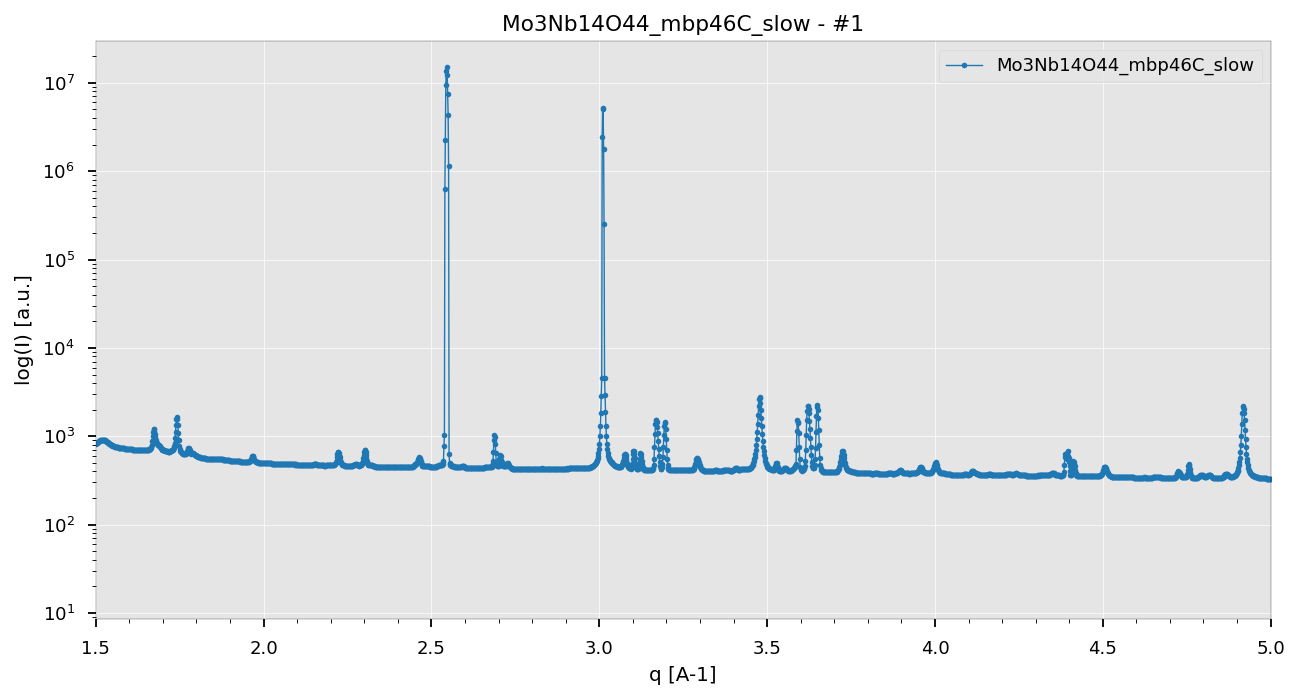

In [51]:
fig3, ax3 = plt.subplots(ncols=1, figsize=(13, 7))

labels = []
processed_scans = list(All_IQs.keys())
NSlider=IntSlider(min=1, max=2, step=1, value=0)
@interact(Scan=Dropdown(options=processed_scans, value=scans[-1]),
          N=NSlider, log=True,
          xlim=FloatRangeSlider(min=0, max=6, value=(1.5, 5), step=0.1),
          overlay=True
         )
def show_iq_diff(Scan, N, xlim, log, overlay):
    if not overlay:
        ax3.cla()
    ax3.grid(True)
    
    q, i_q = All_IQs[Scan]
    NSlider.max = len(i_q)
    
    if Scan not in labels:
        ax3.plot(q, i_q[N-1], 'o-', ms=4, lw=1, label=Scan)
        labels.append(Scan)
    
    ax3.set_xlim(xlim)
    ax3.set_xlabel('q [A-1]')
    ax3.set_ylabel('I [a.u.]')
    if log:
        ax3.set_yscale('log')
        ax3.set_ylabel('log(I) [a.u.]')
        
    ax3.set_title('{} - #{}'.format(Scan, N))
    ax3.legend()
    
    fig3.tight_layout()

In [385]:
fig3, ax3 = plt.subplots(ncols=1, figsize=(13, 7))

labels = []
processed_scans = list(All_IQs.keys())
NSlider=IntSlider(min=1, max=2, step=1, value=0)
@interact(Scan=Dropdown(options=processed_scans, value=scans[-1]),
          N=NSlider, log=True,
          xlim=FloatRangeSlider(min=0, max=6, value=(1.5, 5), step=0.1),
          overlay=Dropdown(options=['overlay', 'diff', 'single'], value='overlay')
         )
def show_iq(Scan, N, xlim, log, overlay):
    if overlay != 'overlay':
        ax3.cla()
    ax3.grid(False)
    
    q, i_q = All_IQs[Scan]
    NSlider.max = len(i_q)
    
    if Scan not in labels:
        if len(labels) == 0:
            i_q0 = i_q[N-1].copy()
            Scan00 = Scan
            
        if overlay == 'diff':
            ax3.plot(q, i_q[N-1] - i_q0, 'o-', ms=4, lw=1, label='{} - {}'.format(Scan, Scan0))
        else:
            ax3.plot(q, i_q[N-1], 'o-', ms=4, lw=1, label=Scan)
            labels.append(Scan)
    
    ax3.set_xlim(xlim)
    ax3.set_xlabel('q [A-1]')
    ax3.set_ylabel('I [a.u.]')
    if log:
        ax3.set_yscale('log')
        ax3.set_ylabel('log(I) [a.u.]')
        
    ax3.set_title('{} - #{}'.format(Scan, N))
    ax3.legend()
    
    fig3.tight_layout()

FigureCanvasNbAgg()

interactive(children=(Dropdown(description='Scan', index=279, options=('LaB6_1Hz_18mm', 'LaB6_0p2Hz_18mm', 'Chamber_0p2Hz_18mm', 'LaB6_0p2Hz_18mm_1', 'LaB6_0p2Hz_18mm_moving', 'LaB6_0p2Hz_18mm_moving_slits_400x100', 'test', 'Ti64_1Hz', 'Ti64_0p5Hz', 'Ti64_0p5Hz_closer', 'Ti64_1Hz_closer', 'Ti64_1Hz_evencloser', 'Chamber', 'Ti64_1Hz_evencloser_', 'Ti64_1Hz_20mm', 'Chamber_20mm', 'Ti64_1Hz_18mm', 'Ti64_1Hz_18mm_slits_250um_60um', 'Ti64_1Hz_18mm_slits_250um_60um_20keV', 'Ti64_s01_r01_test', 's01_r01_test_after', 's01_r01', 's01_r02', 's01_r03', 's01_r03_test_after', 's01_r04_before', 's01_r04', 's01_r04_after', 's01_r05_before', 's01_r05', 's01_r05_after', 's01_r06_before', 's01_r06', 's01_r06_after', 's01_r07_before', 's01_r07', 's01_r07_after', 's01_r08_before', 's01_r08_after', 's01_r08', 's01_r09_before', 's01_r09', 's01_r09_after', 's01_r10_before', 's01_r10', 's01_r10_after', 's01_r11_before', 's01_r11', 's01_r11_after', 's01_r12_before', 's01_r12', 's01_r12_after', 's01_r13_before', 's01_r13', 's01_r13_after', 's02_r01_test', 's02_r00_noSample', 's02_r01_before', 's02_r01', 's02_r01_after', 's02_r02_before', 's02_r02', 's02_r02_after', 's02_r03_before', 's02_r03', 's02_r03_after', 's02_r04_before', 's02_r04', 's02_r04_after', 's02_r05_before', 's02_r05', 's02_r05_after', 's02_r06_before', 's02_r06', 's02_r06_after', 's02_r07_before', 's02_r07', 's02_r07_after', 's02_r08_before', 's02_r08', 's02_r08_after', 's02_r09_before', 's02_r09', 's02_r09_after', 's03_r00_nosample', 's03_r01_before', 's03_r01', 's03_r01_after', 's03_r02_before', 's03_r02', 's03_r02_after', 's03_r03_before', 's03_r03', 's03_r03_after', 's03_r04_before', 's03_r04', 's03_r04_after', 's03_r05_before', 's03_r05', 's03_r05_after', 's04_r01_before', 's04_r01', 's04_r01_after', 's04_r02_before', 's04_r02', 's04_r02_after', 's04_r03_before', 's04_r03', 's04_r03_after', 's04_r04_before', 's04_r04', 's04_r04_after', 's04_r05_before', 's04_r05', 's04_r05_after', 's04_r06_before', 's04_r06', 's04_r06_after', 's04_r07_before', 's04_r07', 's04_r07_after', 's04_r08_before', 's04_r08', 's04_r08_after', 's04_r09_before', 's04_r09', 's04_r09_after', 's04_r10_before', 's04_r10', 's04_r10_after', 's05_r01_before', 's05_r01', 's05_r01_after', 's05_r02_before', 's05_r02', 's05_r02_after', 's05_r03_before', 's05_r03', 's05_r03_after', 's05_r04_before', 's05_r04', 's05_r04_after', 's05_r05_before', 's05_r05', 's05_r05_after', 's05_r06_before', 's05_r06', 's05_r06_after', 's05_r07_before', 's05_r07', 's05_r07_after', 's05_r08_before', 's05_r08', 's05_r08_after', 's05_r09_before', 's05_r09', 's05_r09_after', 's06_r01_before', 's06_r01', 's06_r01_after', 's06_r02_before', 's06_r02', 's06_r02_after', 's06_r03_before', 's06_r03', 's06_r03_after', 's06_r04_before', 's06_r04', 's06_r04_after', 's06_r05_before', 's06_r05', 's06_r05_after', 's06_r06_before', 's06_r06', 's06_r06_after', 's06_r07_before', 's06_r07', 's06_r07_after', 's06_r08_before', 's06_r08', 's06_r08_after', 's06_r09_before', 's06_r09', 's06_r09_after', 's06_r10_before', 's06_r10', 's06_r10_after', 's06_r11_before', 's06_r11', 's06_r11_after', 's07_r01_before', 's07_background', 's07_r01', 's07_r01_after', 's07_r02_before', 's07_r02', 's07_r02_after', 's07_r03_before', 's07_r03', 's07_r03_after', 's07_r04_before', 's07_r04', 's07_r04_after', 's07_r05_before', 's07_r05', 's07_r05_after', 's07_r06_before', 's07_r06', 's07_r06_after', 's07_r07_before', 's07_r07', 's07_r07_after', 's07_r08_before', 's07_r08_after', 's07_r09_before', 's07_r09', 's07_r09_after', 's07_r10_before', 's07_r10_after', 's07_r11_before', 's07_r11_after', 's07_r12_before', 's07_r13', 's07_r13_after', 's07_r14', 's07_r14_after', 's08_r00_test', 's08_r01_before', 's08_r01', 's08_r01_after', 's08_r02_before', 's08_r02', 's08_r02_after', 's08_r03_before', 's08_r03', 's08_r03_after', 's08_r04_before', 's08_r04', 's08_r04_after', 's08_r05_before', 's08_r05', 's08_r05_after', 's08_r06_before', 's08_r06', 's08_r06_after', 's08_r07_before', 's08_r07', 's08

In [182]:
scan = 'LaB6_1Hz_closer_slits_400x60_rocking'
images = get_images(FNames[scan])
for nn, im in enumerate(images):
    im[514:551, :] = np.nan
    im[0, 1029] = np.nan
    if nn == 0:
        im_sum = im
    else:
        im_sum += im
    imwrite(os.path.join(calib_path, '{}.tiff'.format(scan)), im_sum)

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,7))

@interact(scan=All_IQs.keys(), N=range(len(images)))
def show_iq(scan, N):
    if scan in Images.keys():
        images = Images[scan]
    else:
        images = get_images(FNames[scan], im_range)
        #remove_outliers(images, ai.mask)
        Images[scan] = images
    
    if scan not in All_IQs.keys():
        iq_file   = '{}/IQ_{}.h5'.format(save_path, scan)
        with h5py.File(iq_file, 'r') as h5file:
            All_IQs[scan] = h5file['I_Q'].value

    q, iq, err_iq = All_IQs[scan]

    ax1.cla()
    ax2.cla()
    
    fac = 1
    if scan[:4] == 'bg_1':
        fac = 1e3
    elif scan[:4] == 'bg_0':
        fac = 5e3
        
    ax2.plot(q[N], iq[N]/fac, 'o-')
    ax2.set_xlim(2,4)
    ax2.set_ylim(0,1)
    
    im = images[N]
    ax1.imshow(im, vmin=np.percentile(im, 5), vmax=np.percentile(im[im<im.max()], 95))
    
    plt.tight_layout()

FigureCanvasNbAgg()

interactive(children=(Dropdown(description='scan', options=('s42_r01',), value='s42_r01'), Dropdown(description='N', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796,

In [44]:
def get_scans(sample_paths):
    FNames = OrderedDict()#{sample:[] for sample in samples})

    for scan, scan_path in scan_paths.items():
        img_paths = glob.glob(f'{scan_path}/*.tif')
        
        
    for img_path in img_paths:
        for sample in samples:
            if f'{sample}_scan' in img_path:
                FNames[sample].append(img_path)
                break

    for scan in FNames.keys():
        fnames = np.asarray(FNames[scan])
        inds = np.asarray(np.argsort([int(f[f.rfind('_scan')+5:]) for f in fnames]), dtype=int)
        sorted_fnames = list(fnames[inds])
        FNames[scan] = sorted_fnames
        
    samples = list(FNames.keys())

    return FNames, samples

FNames, samples = get_scans(data_path)

for k, v in FNames.items():
    print(f'scan: {k}, nimages: {len(v)}')

scan: PNb9O25_mbp29C_5C, nimages: 5
scan: PNb9O25_mbp29C_10C, nimages: 3
scan: PNb9O25_mbp29C_20C, nimages: 2
scan: W3Nb14O44_mbp51F_slow, nimages: 1071
scan: PNb9O25_mbp29C_slow, nimages: 1062
scan: Mo3Nb14O44_mbp46C_slow, nimages: 1069


In [24]:
fig2, (ax21, ax22) = plt.subplots(ncols=2, figsize=(16,7))

@interact(scan=All_IQs.keys(), N=range(len(images)))
def show_iq(scan, N):
    if scan in Images.keys():
        images = Images[scan]
    else:
        images = get_images(scan, FNames[scan], im_range)
        #remove_outliers(images, ai.mask)
        Images[scan] = images
    
    if scan not in All_IQs.keys():
        iq_file   = '{}/IQ_{}.h5'.format(save_path, scan)
        with h5py.File(iq_file, 'r') as h5file:
            All_IQs[scan] = h5file['I_Q'].value

    q, iq, err_iq = All_IQs[scan]

    ax21.cla()
    ax22.cla()
    
    fac = 1
    if scan[:4] == 'bg_1':
        fac = 1e3
    elif scan[:4] == 'bg_0':
        fac = 5e3
        
    ax22.plot(q[N], iq[N]/fac, 'o-')
    ax22.set_xlim(2,4)
    ax22.set_ylim(0,1)
    
    im = images[N]
    ax21.imshow(im, vmin=np.percentile(im, 5), vmax=np.percentile(im, 95))
    
    plt.tight_layout()

FigureCanvasNbAgg()

interactive(children=(Dropdown(description='scan', options=('s03_r02', 's03_r03', 's03_r04', 'bg_0p2Hz', 'bg_1Hz'), value='s03_r02'), Dropdown(description='N', options=(0,), value=0), Output()), _dom_classes=('widget-interact',))

### Background Data

scans = ['bg_0p2Hz', 'bg_1Hz']

for scan in scans:
    fnames = [fname for fname in glob.glob(os.path.join('{}/align'.format(image_path),
                                                        '{}_*_data*.h5'.format(scan)))]

    if len(fnames) != 0:
        FNames[scan] = list(np.sort(fnames))
        
scans = list(FNames.keys())

fig, ax1 = plt.subplots(ncols=1, figsize=(6,6))

@interact(scan=scans, N=range(10))
def show_image(scan, N=0):
    images = get_images(scan, [0,10])

    im = images[N]
    ax1.imshow(im, vmin=np.percentile(im, 5), vmax=np.percentile(im, 95))